In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from google.colab import drive

drive.mount('/content/drive')

PROJECT_PATH = '/content/drive/MyDrive/Competicao_DS_Arquivos'

!unzip $PROJECT_PATH/digit-recognizer.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/MyDrive/Competicao_DS_Arquivos/digit-recognizer.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
X = train_data.iloc[:,1:]
y = train_data.iloc[:,0]

X_test = test_data.iloc[:,1:]
y_test = test_data.iloc[:,0]

In [4]:
#É um fato conhecido que o dataset de MNIST possui uma estrutura/ordenação já "embaralhada", portanto, uma simples separação em indices deve bastar
#Utiliza-se a proporção recomendada 70/30

#Assim 29400 imagens serao aderidas ao conjunto de treino e 12600 para validação
X_train = X.iloc[:29400,:]
y_train = y.iloc[:29400]

X_val = X.iloc[29400:,:]
y_val = y.iloc[29400:]

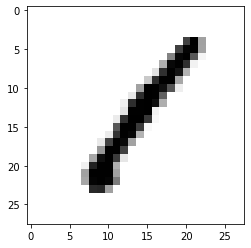

In [5]:
#Para podermos observar apenas uma instancia devemos inicialmente seguir a especificação de 28x28 do dataset, para isso utiliza-se o reshape, seguido do uso da funcionalidade imshow do matplotlib

#Exemplo
plt.imshow(X_train.iloc[0,:].to_numpy().reshape(28,28),cmap = "binary");

#Questão 1 (valor 2,5 pontos)

##a) Faça o plot de uma imagem de cada uma das classes do problema.

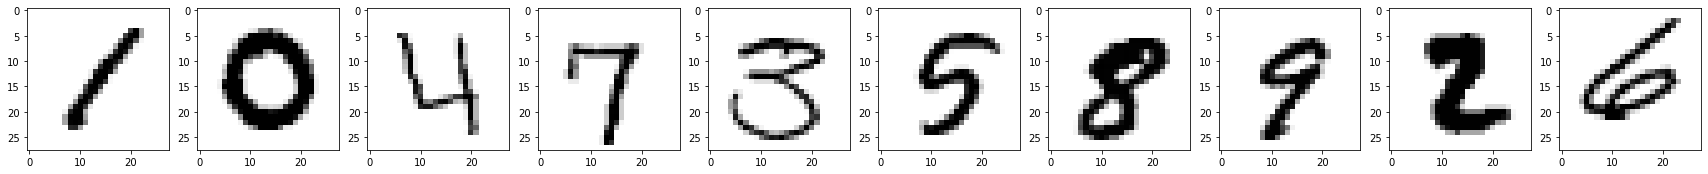

In [6]:
mostradas = []

fig, axs = plt.subplots(1,10,figsize=(30,30))

for i in range(len(y_train)):
  if y_train[i] not in mostradas:
    axs[len(mostradas)].imshow(X_train.iloc[i,:].to_numpy().reshape(28,28),cmap = "binary")
    mostradas.append(y_train[i])

##b) Faça um histograma mostrando a distribuição das classes do problema.
##Discuta este histograma.

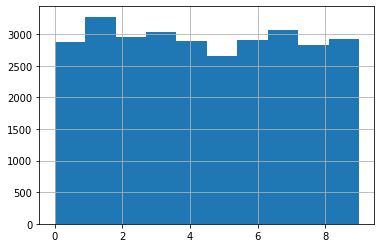

In [7]:
y_train.hist(bins = 10);

Como podemos ver, existe uma homogeneidade na distribuição das classes, como garantido pela distribuição padrão do dataset MNIST. Como maior frequência para o digito 1 e menor para o digito 5, porém com uma diferença ainda assim pequena relativa ao tamanho absoluto do conjunto. 

In [8]:
y_train.describe()

count    29400.000000
mean         4.453810
std          2.882268
min          0.000000
25%          2.000000
50%          4.000000
75%          7.000000
max          9.000000
Name: label, dtype: float64

Como mostrado logo acima, a média está realmente próxima de 5, porém como uma maior prevalescencia de valores menores que 5, o que não deve ser um problema.


Por conta da não existência de um desbalanciamento de classe significativo existe uma possibilidade de aplicação (como sugerido no enunciado da questão 3a e 4b) da métrica de acurácia como válida para a resolução deste problema, embora não seja o recomendado para classificação multiclasse (recomenda-se entropia cruzada).

#Questão 2 (valor 2,5 pontos)

## a) Detecte variáveis que não são úteis para o modelo e remova elas da base de
##dados. Justifique a remoção de tais variáveis. Obs.: as variáveis não podem
##ser nenhum pouco úteis.

Para termos noção de quais variáveis não são úteis podemos usar de forma computacional ou a partir de conhecimentos prévios da natureza do problema.

Como se trata de uma imagem, embora de baixa resolução, cada pixel em si não possui uma grande importância para o problema, pois o que importa para 
o reconhecimento da imagem seria a forma com que grandes números de pixels se arranjam localmente de forma que globalmente partes primitivas (traços,
círculos, ligações, etc) sejam estruturadas e reconhecidas dentro de um conjunto predefinido de 10 valores. Sendo assim, mais algumas coisas se aplicam,
como o fato de que (até certo nível) nem sequer estas estruturas estão tão bem definidas dentro de um padrão pois, como pudemos ver na primeira imagem, 
um dígito 1 ainda pode ser reconhecido como tal mesmo que não esteja nem de perto com a base perpendicular ao "solo". Assim, podemos inferir que embora as
imagens possuem 784 dimensões cada, na realidade o conjunto daquilo que define cada classe precisa de muitos menos graus de liberdade, dadas as simetrias e/ou
invariâncias do problema em si.

De um ponto de vista mais prático, algumas outras simetrias não serão detectadas pelo algoritmo provavelmente, como a de translação. É possível afirmar tal pois
espera-se que um processo de curação das imagens tenha sido realizado de forma que estejam, em média, centradas, pouco rotacionadas e com traços relativamente mais
bem definidos, portanto, por conta disso, o modelo teria dificuldades em identificar um 1 mais fraco ou um 2 mais rotacionado.

Partindo agora de um ponto de vista computacional, podemos realizar duas coisas:

*detectar a partir de um algoritmo de previsão quais são as variáveis que menos auxiliaram no processo 
*verificar quais são as dimensões (variáveis) mais importantes para a resolução do problema através de algum procedimento de redução de dimensionalidade

Por vias de escolha escolhe-se a primeira opção, por razões de visualização que ficarão mais claras logo a seguir

In [9]:
from sklearn.ensemble import RandomForestClassifier

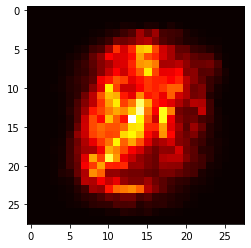

In [10]:
#Como modelo de previsão que fará a estimativa da importancia das features recorre-se para a robusta RandomForest, por conta da facilidade de descoberta de
#importancias atraves de métodos já implementados

RF = RandomForestClassifier(n_estimators=100, random_state=42)
RF.fit(X_train,y_train)

plt.imshow( RF.feature_importances_.reshape(28, 28), cmap = mpl.cm.hot,interpolation="nearest")

plt.show()

Como esperado temos que as features mais ao centro possuem em média maior importância, e que o formato é aproximadamente o de uma elipse (pois o eixo vertical é, como esperado, maior que o horizontal).

Sendo assim, temos que esta estimativa do modelo de Random Forests parece sim concordar com aquilo que a intuição nos diz, e com isso as regiões mais escuras podem ser tomadas como de importância tão baixa que fundamentalmente não são nem um pouco úteis.

In [11]:
importancias = RF.feature_importances_
importancias.max(), importancias.min(), importancias.sum()

(0.009244000730673213, 0.0, 1.0)

In [12]:
#Como o alcance é entre 0 e 1 para este array, com soma de todas dando 1, temos que arbitrar uma threshold a partir do qual valores abaixo disso não são considerados como úteis para o modelo
#Se tomarmos como definição de nem um pouco úteis (algo um pouco controverso por conta de problemas de precisão numérica, dados insuficientes, etc) o valor 0, 
#temos uma redução significativa de variáveis, com 133 valores nulo, ou 17% do total
(importancias == 0).sum(), (importancias == 0).mean()

(133, 0.16964285714285715)

In [13]:
#Elminando estas variáveis temos
colunas_inuteis = importancias == 0
X_train.drop(X_train.columns[colunas_inuteis],axis = 1, inplace = True)
X_val.drop(X_val.columns[colunas_inuteis],axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


##b) Usando o critério do item anterior é possível inferir que algumas variáveis
##devem ter pouca importância para os modelos que iremos construir?

Como fora discutido anteriormente, temos que as variáveis mais às extremidades da imagem provavelemente possuem pouco valor semantico, com algumas inclusive contando com 0 de importância, sendo assim a 'centralidade' do pixel um maior indicativo da classe real. Para melhorar o desempenho da classificação escolhe-se ainda uma redução de dimensionalidade, por conta das simetrias do problema mesmo dentro da área não retirada. 

Muitas formas podem ser comumente usadas, como KernelPCA, t-SNE, Isomap, LLE ou algo mais sofisticado. Como o problema não é esperado ser linear, a utilização de PCA pode não ser muito útil, por outro lado procura-se manter uma noção simples inicialmente (deixando as não-linearidades para o modelo) opta-se pela utilização de PCA mesmo assim.

#Questão 3 (valor 2,5 pontos)

##a) Comparar vários modelos candidatos e escolher o melhor de acordo com a
##acurácia. Usar pelo menos uma rede neural.

Embora tenhamos separado em treino e validação no começo, isso fora feito mais por conta da questão 4, sendo que para tarefas em altas dimensões como essa (sem contar o número relativamente baixo de amostras e complexidade do tratamento de imagens, com todas as suas simetrias e invariâncias não-lineares) é melhor o uso de GridSearchCV para seleção do modelo em si, sem contar a conveniência de sua realização em conjunto com uma pipeline inteira.

Para facilitar o teste de varios modelos em uma unica pipeline, usa-se esta classe definida no segundo trabalho

In [14]:
from sklearn.base import BaseEstimator

class ClfSwitcher(BaseEstimator):

  def __init__(self,estimator = RandomForestClassifier(n_estimators=100,max_depth=3)):
      self.estimator = estimator
      return 

  def fit(self, X, y=None, **kwargs):
      self.estimator.fit(X, y)
      return self

  def predict(self, X, y=None):
      return self.estimator.predict(X)

  def predict_proba(self, X):
      return self.estimator.predict_proba(X)

  def score(self, X, y):
      return self.estimator.score(X, y)

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC 
#alem de RandomForestClassifier ja importado

from sklearn.decomposition import PCA

pipeline = Pipeline(steps = [
    ('PCA', PCA(n_components = 0.95)),
    ('clf', ClfSwitcher())
])

param_grid = {
    'clf__estimator': [LogisticRegression(),MLPClassifier(),RandomForestClassifier(),SVC()]
}

gridCV = GridSearchCV(pipeline,param_grid,cv = 3, scoring = 'accuracy')

In [16]:
X.drop(X.columns[colunas_inuteis],axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [17]:
gridCV.fit(X,y)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('PCA', PCA(n_components=0.95)),
                                       ('clf', ClfSwitcher())]),
             param_grid={'clf__estimator': [LogisticRegression(),
                                            MLPClassifier(),
                                            RandomForestClassifier(), SVC()]},
             scoring='accuracy')

In [18]:
gridCV.best_estimator_, gridCV.best_score_ 

(Pipeline(steps=[('PCA', PCA(n_components=0.95)),
                 ('clf', ClfSwitcher(estimator=SVC()))]), 0.9776190476190476)

Embora (por razões de RAM consumida pelo colab, além de tempo de processamento) não tenham sido testados uma variedade muito grande de modelos, pelo score conseguido pelo melhor modelo (97,8% pelo SVC genérico) temos já uma acurácia muito boa.

##b) Gerar os resultados do melhor modelo na base de teste e enviar para o
##Kaggle. Colocar alguma evidência do envio no projeto entregue.

In [19]:
#Vamos verificar antes como devem ser enviadas as previsões
sample_sub_data = pd.read_csv('sample_submission.csv')
sample_sub_data

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
27995,27996,0
27996,27997,0
27997,27998,0
27998,27999,0


In [24]:
#Vamos realizar as previsões primeiramente
X_test = test_data.drop(test_data.columns[colunas_inuteis],axis = 1)

In [25]:
y_test = gridCV.predict(X_test)

In [29]:
ImageId = np.arange(1,len(y_test)+1)
submission = pd.DataFrame({'ImageId' : ImageId, 'Label' : y_test})

In [30]:
submission

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [32]:
submission.to_csv('MinhaSubmissao.csv', index=False)

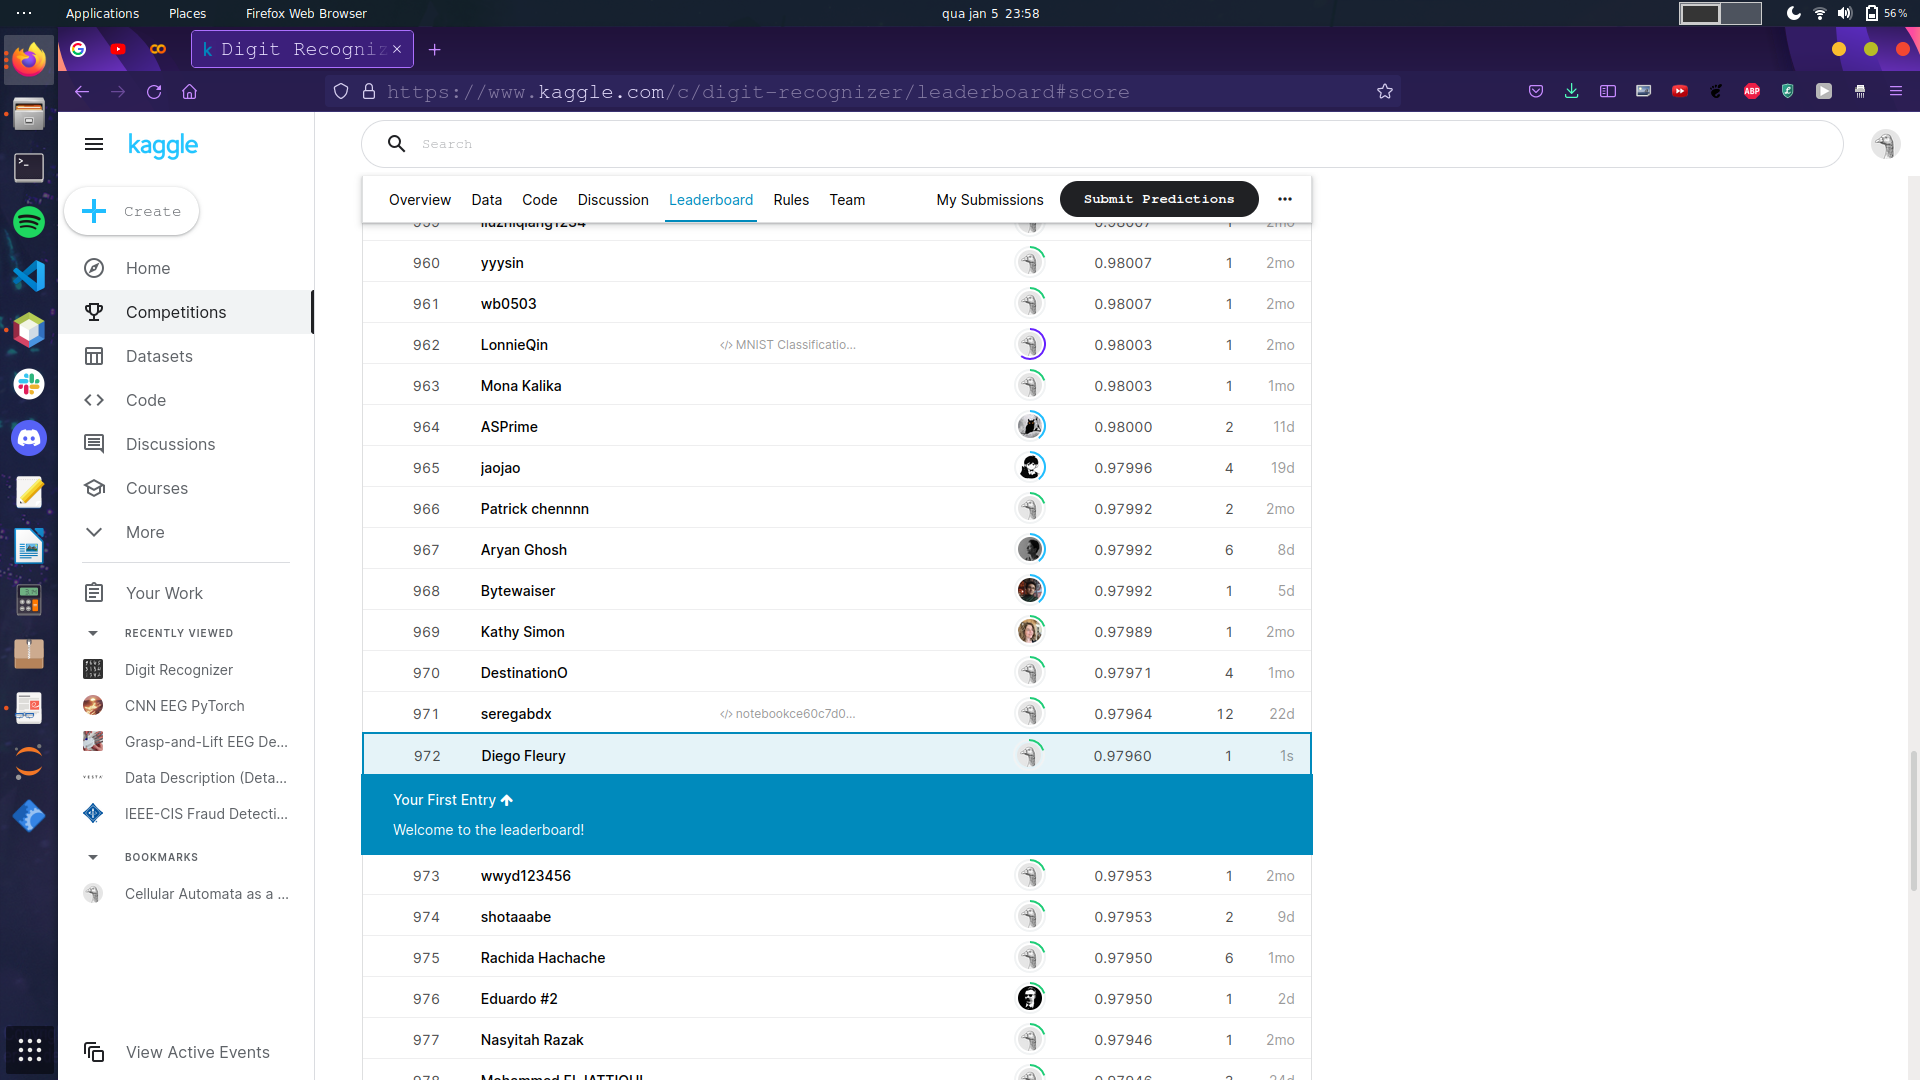

In [33]:
from IPython.display import Image
Image('ProvaSubmissao.png')

#Questão 4 (valor 2,5 pontos)

##a) Calcular a acurácia e a matriz de confusão do melhor modelo. Para fazer este
##item siga os seguintes passos:
* Divida a base de treinamento em 2 partes (70/30%)
* Treine o modelo na primeira parte
* calcule os resultados na
segunda
* Use os hiperparâmetros do melhor modelo da questão 3.

In [34]:
Modelo = Pipeline(steps = [
    ('PCA', PCA(n_components = 0.95)),
    ('clf', ClfSwitcher())
])

Modelo.fit(X_train,y_train)

Pipeline(steps=[('PCA', PCA(n_components=0.95)), ('clf', ClfSwitcher())])

In [35]:
y_preds = Modelo.predict(X_val)

In [36]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [37]:
acuracia_modelo = accuracy_score(y_val,y_preds)
acuracia_modelo

0.7607936507936508

In [58]:
matriz_confusao = confusion_matrix(y_val, y_preds)

matriz_confusao

array([[1041,   20,   10,   95,    1,    2,   61,   17,   13,    3],
       [   0, 1340,   27,   15,    0,    0,    4,    1,   22,    0],
       [  14,   39,  906,   91,   15,    1,   23,   13,  119,    5],
       [   4,   28,   65, 1107,    0,    7,   34,   20,   40,   12],
       [   5,   41,   13,   28,  919,    4,   25,   22,   21,  106],
       [  48,   24,   56,  279,   26,  390,  113,   43,   97,   59],
       [  19,    8,   45,   18,   23,   16, 1069,   12,   16,    1],
       [  12,   94,   13,   22,   17,    1,    3, 1099,   31,   40],
       [  19,   48,   33,  100,   16,   11,   30,   37,  892,   49],
       [   7,   59,   12,   46,  144,    9,    3,  133,   36,  823]])

##b) O modelo tem um resultado parecido para todas as classes, ou há uma
##grande diferença em seu comportamento (quantidade acertos e erros) para
##diferentes classes?

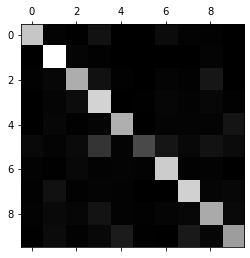

In [59]:
#Vamos usar uma visualização por cores (mais claro ==> maior o numero)
plt.matshow(matriz_confusao,cmap=plt.cm.gray)
plt.show()

#como nao é muito util a informacao de que a diagonal é o mais esperado, vamos zerar estes valores, para melhorar a visualização dos ERROS em si, alem de normalizar (antes) pela quantidade em cada linha

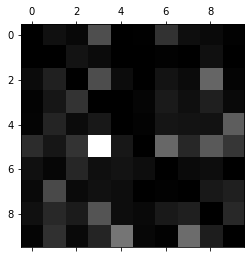

In [60]:
matriz_confusao_nova = matriz_confusao / matriz_confusao.sum(axis = 1, keepdims=True)

for i in range(10):
  matriz_confusao_nova[i][i] = 0

plt.matshow(matriz_confusao_nova,cmap=plt.cm.gray)
plt.show()

In [61]:
#Por conta do fato que queremos saber de ERROS em si, vamos calcular a media baseando-se nos erros cometidos por linha e colunas
erros_linha = {}
erros_coluna = {}

for i in range(10):
  erros_linha[i] = matriz_confusao_nova[i].mean() * 10 / 9
  erros_coluna[i] = matriz_confusao_nova[:,i].mean() * 10 / 9

In [62]:
erros_linha

{0: 0.019530219055159673,
 1: 0.005441211260941566,
 2: 0.02900126880551024,
 3: 0.017717033662363955,
 4: 0.02486861861861862,
 5: 0.07293196279980421,
 6: 0.014307706239246583,
 7: 0.019436102769436102,
 8: 0.030859199280251912,
 9: 0.03922082459818309}

In [63]:
erros_coluna

{0: 0.011816874317512396,
 1: 0.03189120613573716,
 2: 0.02437143332926185,
 3: 0.06420821752659117,
 4: 0.021511649632951928,
 5: 0.004540635586363144,
 6: 0.027254402060598554,
 7: 0.02674723490420403,
 8: 0.03568407550218587,
 9: 0.025288418094109852}

Vemos na matriz de confusao um GRANDE ponto de interesse: Sabendo que as colunas sao as PREVISOES e as linhas sao as classes em si, temos que o ponto branco indica o fato de que muitos cincos sao classificados incorretamente como 3. Inclusive, olhando para a coluna inteira de 3, temos que o valor é o maior dos erros, indicando que o modelo classifica de modo incorreto muitos digitos como 3 (quase 2x mais que o segundo colocado em erros das colunas). 

Para com relação às linhas, temos que a classe que mais é classificada erroneamente é o 5, sendo esta novamente possuindo aproximadamente o dobro dos erros do segundo colocado.

Isso tudo nos leva a crer que o modelo tem um viés a classificar várias imagens como o número 3 e tem dificuldades de classificação do número 5, sendo isso de certa forma uma boa notícia, pois implica que apenas um reforço maior nessas duas áreas já melhora o poder preditivo consideravelmente.

Enfim, apenas como medida de curiosidade e observação, vamos verificar a simetria dos erros, ou seja, se a probabilidade de A ser confundido com B é parecida com de B ser confundido com A, até que ponto isso vale e quais são os melhores e piores casos deste tipo de erro.

In [64]:
simetria_erros = np.zeros((10,10))
for i in range(10):
  for j in range(10):
    simetria_erros[i][j] = np.abs(matriz_confusao_nova[i][j] - matriz_confusao_nova[j][i])
    simetria_erros[j][i] = simetria_erros[i][j]

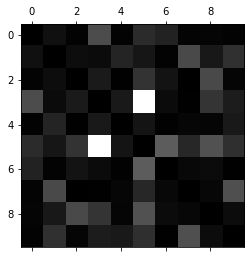

In [66]:
plt.matshow(simetria_erros,cmap=plt.cm.gray)
plt.show()

Temos, novamente, que a maior ASSIMETRIA de classificação ocorre nesta intersecção de 3 com 5, sendo nenhuma outra parecida em todo o conjunto, novamente, indicando boas noticias, pois implica que em grande parte o modelo pode melhorar apenas nesse quesito e ja possuir uma maior acuracia, possivelmente suficientemente grande para a aplicação em maos, sendo esse treino possivelmente uma maior quantidade de dados 3 e 5 para que aprenda a distingui-los.

In [70]:
simetria_erros.argmax(), simetria_erros.max()

(35, 0.24049986787485908)